In [2]:
import pandas as pd
from pathlib import Path

In [3]:
base_output_dir = Path("../output")
known_1000_correct_files = {
    tuple(experiment_path.name.rsplit('_', maxsplit=1)): pd.read_csv(known_1000_correct_files)
    for experiment_path in base_output_dir.iterdir()
    if (known_1000_correct_files := experiment_path / 'evaluate' / "known_1000_correct.csv").exists()
}

In [4]:
# sort known_1000_correct_files by experiment name
known_1000_correct_files = dict(sorted(known_1000_correct_files.items()))

# Iterate through the sorted dictionary and print in hierarchical format
current_arch = None
for (arch_name, size), df in known_1000_correct_files.items():
    if arch_name != current_arch:
        if current_arch is not None:
            print()  # Add a newline between different architectures
        print(f"{arch_name}:")
        current_arch = arch_name
    print(f"   {size}")

minimal_mamba1:
   130M
   2.8B

minimal_mamba2:
   130M
   2.7B


In [43]:
# Predefined constants for column names
INDEX_COL = 'known_id'
TOTAL_CORRECT_COL = 'total_correct'
AGGREEMENT_TYPE_COL = 'agreement_type'
MODEL_CORRECT_COL = 'model_correct'
INDEX_COLUMNS = ['arch_name', 'size']
PER_MODEL_COLS = [MODEL_CORRECT_COL, 'model_output']
SHARE_COLS = [col for col in df.columns if col not in PER_MODEL_COLS + [INDEX_COL]]
SHARE_COLS = ['prompt', 'relation_id']

# Processing the data using pipes
result = (
    pd.concat([
        df.assign(arch_name=name[0], size=name[1])
        for name, df in known_1000_correct_files.items()
    ])
    .set_index(INDEX_COL)
    .pipe(lambda df: (
        pd.concat([
            df[PER_MODEL_COLS + INDEX_COLUMNS]
            .set_index(INDEX_COLUMNS, append=True)
            .unstack(level=[-2, -1]),
            df[SHARE_COLS].drop_duplicates().sort_index(),
        ], axis=1)
    ))
    .pipe(lambda df: df.assign(**{
        TOTAL_CORRECT_COL: df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]].sum(axis=1),
        AGGREEMENT_TYPE_COL: (
            df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]]
            .astype(int)
            .apply(lambda x: ''.join(x.astype(str)), axis=1)
        )
            
    }))
)

# Displaying the result
result.head(20)

,"(model_correct, minimal_mamba1, 130M)","(model_correct, minimal_mamba1, 2.8B)","(model_correct, minimal_mamba2, 130M)","(model_correct, minimal_mamba2, 2.7B)","(model_output, minimal_mamba1, 130M)","(model_output, minimal_mamba1, 2.8B)","(model_output, minimal_mamba2, 130M)","(model_output, minimal_mamba2, 2.7B)",prompt,relation_id,total_correct,agreement_type
known_id,,,,,,,,,,,,
0,False,True,True,True,Africa,Antar,Antar,Antar,Vinson Massif is located in the continent of,P30,3,0111
1,False,True,False,True,Be,Apple,the,Apple,Beats Music is owned by,P127,2,0101
2,False,True,False,True,Aud,Amazon,the,Amazon,Audible.com is owned by,P127,2,0101
3,False,True,False,True,ABC,CBS,Sunday,CBS,The Big Bang Theory premieres on,P449,2,0101
4,True,False,False,False,Apple,Mac,the,the,"MacApp, a product created by",P178,1,1000
5,True,True,False,False,Italy,Italy,the,the,"Giuseppe Angeli, who has a citizenship of",P27,2,1100
6,True,True,False,True,Europe,Europe,the,Europe,Catalonia belongs to the continent of,P30,3,1101
7,True,True,True,True,English,English,English,English,"In Marshall Islands, the language spoken is a ...",P37,4,1111
8,False,True,False,True,the,CBS,the,CBS,Leslie Moonves is employed by,P108,2,0101


In [20]:
# print value counts for total_correct
(
    result[TOTAL_CORRECT_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")    
)

total_correct
2    31.93%
3    20.35%
4    17.12%
1    15.63%
0    14.97%
Name: proportion, dtype: object

In [22]:
# print value counts for agreement_type
agreement_type_counts = (
    result[AGGREEMENT_TYPE_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")    
)
agreement_type_counts

agreement_type
0101    23.66%
1111    17.12%
0000    14.97%
1101    10.34%
0111     6.12%
0100     6.04%
0001     6.04%
1110     2.48%
1100     2.23%
1000     2.07%
1010     2.07%
1001     1.57%
0010     1.49%
1011     1.41%
0110     1.32%
0011     1.08%
Name: proportion, dtype: object

In [30]:
result['relation_id'].value_counts().tail(10)

relation_id
P131     28
P413     28
P740     26
P1303    26
P136     25
P463     20
P1412    19
P106     16
P138      9
P190      1
Name: count, dtype: int64

In [40]:
top_relation_ids = (
    result
    .pipe(lambda df: df[df['relation_id'].map(df['relation_id'].value_counts()) >= 25])
    .groupby('relation_id')[AGGREEMENT_TYPE_COL]
    .value_counts(normalize=True)
    .groupby(level=0)
    .head(100)
    .unstack(level=0)
)

top_relation_ids


relation_id,P101,P103,P108,P127,P1303,P131,P136,P140,P159,P17,...,P364,P37,P39,P407,P413,P449,P495,P641,P740,P937
agreement_type,,,,,,,,,,,,,,,,,,,,,
0000,0.222222,NaN,0.061224,0.162791,0.192308,0.357143,0.36,0.073171,0.085106,0.021739,...,0.029412,0.130435,0.384615,0.066667,0.214286,0.18,0.081081,0.052632,0.423077,0.150
0001,0.044444,NaN,0.061224,0.116279,0.076923,0.071429,0.04,0.073171,0.106383,0.021739,...,0.029412,NaN,0.025641,0.111111,0.035714,0.10,0.216216,0.105263,0.076923,0.100
0010,NaN,NaN,0.040816,NaN,NaN,0.035714,NaN,NaN,0.042553,NaN,...,NaN,0.021739,NaN,0.044444,NaN,NaN,NaN,NaN,NaN,0.025
0011,0.088889,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,0.021739,...,NaN,NaN,0.051282,NaN,NaN,0.02,0.027027,NaN,NaN,NaN
0100,0.066667,0.021277,0.020408,0.023256,0.115385,0.107143,0.12,0.024390,0.063830,0.152174,...,0.058824,0.043478,0.102564,0.044444,0.107143,0.12,NaN,0.026316,0.115385,NaN
0101,0.155556,NaN,0.489796,0.465116,0.269231,0.250000,0.20,0.317073,0.404255,0.239130,...,0.147059,0.239130,0.076923,0.200000,0.250000,0.36,0.459459,0.263158,0.153846,0.075
0110,0.022222,NaN,NaN,NaN,NaN,0.035714,0.04,0.024390,NaN,0.021739,...,0.029412,NaN,NaN,NaN,NaN,0.02,NaN,0.026316,NaN,NaN
0111,0.066667,0.021277,0.163265,0.046512,0.038462,NaN,0.04,NaN,0.063830,0.043478,...,0.029412,0.043478,0.128205,0.066667,0.035714,0.08,0.081081,0.131579,NaN,0.050
1000,0.044444,NaN,NaN,NaN,0.038462,NaN,NaN,0.024390,NaN,NaN,...,0.088235,0.021739,0.051282,NaN,0.035714,NaN,NaN,NaN,0.038462,0.025


In [41]:
top_relation_ids.sum()

relation_id
P101     1.0
P103     1.0
P108     1.0
P127     1.0
P1303    1.0
P131     1.0
P136     1.0
P140     1.0
P159     1.0
P17      1.0
P176     1.0
P178     1.0
P19      1.0
P20      1.0
P27      1.0
P276     1.0
P30      1.0
P36      1.0
P364     1.0
P37      1.0
P39      1.0
P407     1.0
P413     1.0
P449     1.0
P495     1.0
P641     1.0
P740     1.0
P937     1.0
dtype: float64

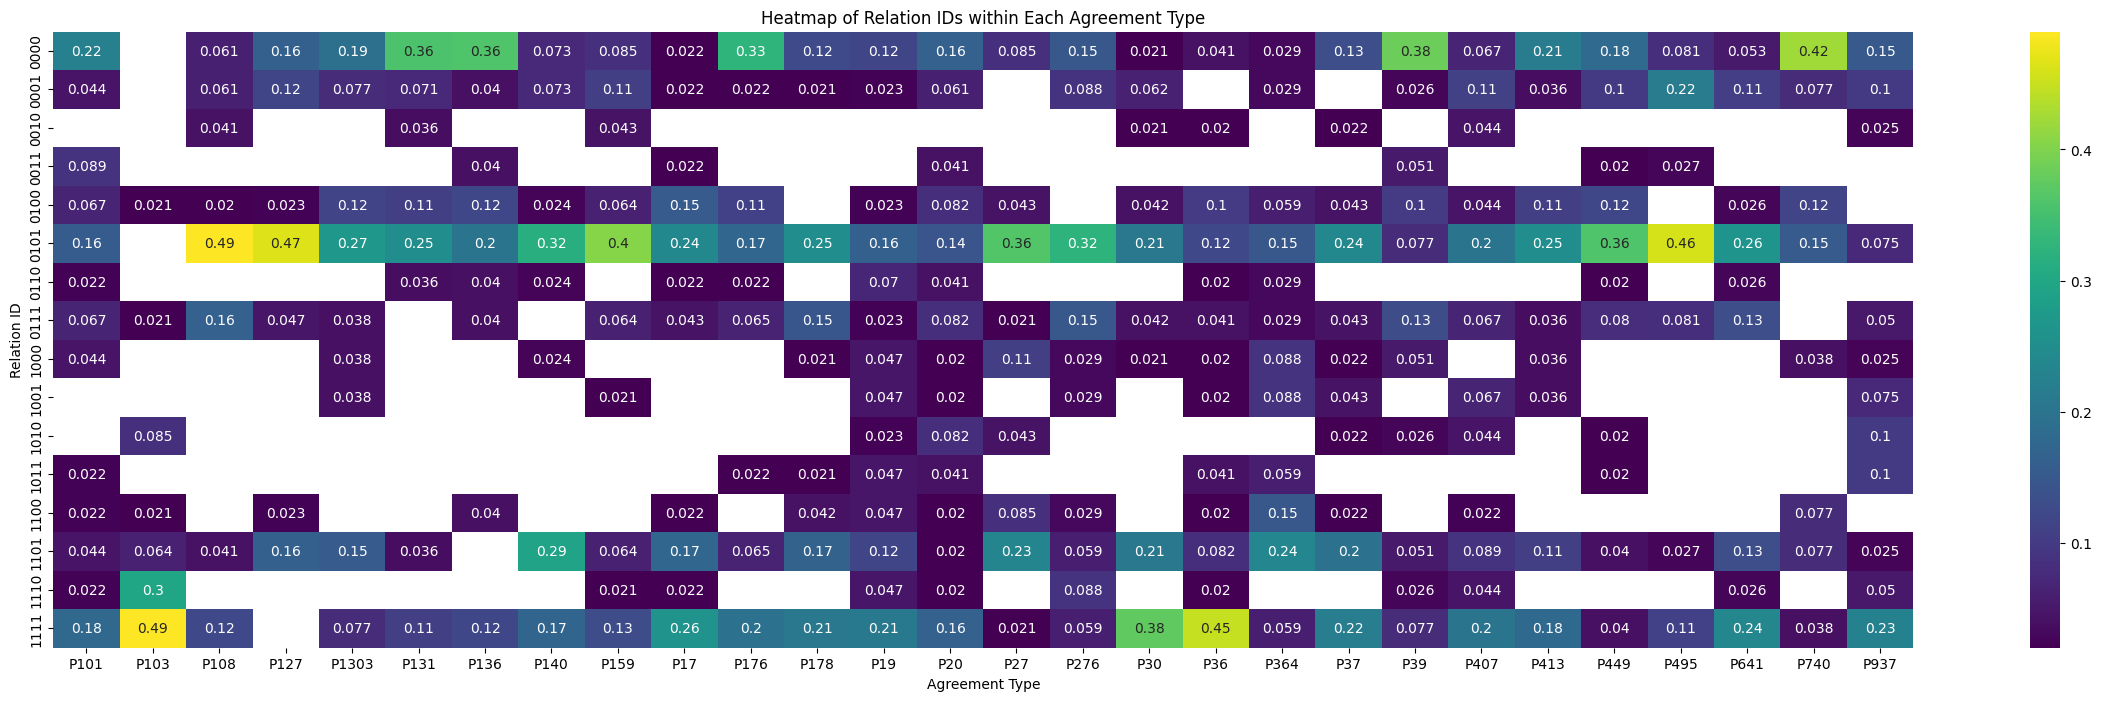

In [42]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a heatmap for the relation_ids DataFrame
plt.figure(figsize=(30, 8))
sns.heatmap(top_relation_ids, annot=True, cmap='viridis', cbar=True)
plt.title('Heatmap of Relation IDs within Each Agreement Type')
plt.xlabel('Agreement Type')
plt.ylabel('Relation ID')
plt.show()